In [1]:
from functools import partial

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar

from models.data import SynthCardDataModule
from models.mae.mae import ViTAE
from models.encoders import DinoViT_16, DinoViT_8, Dinov2ViT_14, ResNet34_8x8, get_resnet34_encoder
from models.segmentation import ObjectSpecificSegmentation

from pytorch_lightning.loggers import WandbLogger
from pathlib import Path

from torch_uncertainty.metrics import AURC, AUSE
from torch_uncertainty.metrics.classification import CalibrationError
from monai.networks import one_hot
from torch_uncertainty.transforms.corruptions import (
    GaussianNoise,
    SpeckleNoise,
)

In [2]:
def image_overlay(batch, image_num, pixel_entropy):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    ax.imshow(batch['image'][image_num].squeeze().cpu(), cmap='gray')
    ax.imshow(pixel_entropy, cmap='plasma', alpha=0.5)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

def ground_truth_overlay(batch, image_num, pixel_entropy):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    ax.imshow(batch['labelmap'][image_num].squeeze().cpu(), cmap='gray')
    ax.imshow(pixel_entropy, cmap='plasma', alpha=0.5)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

def uncertainty_metrics(oss, batch, trials=500, transform='GaussianNoise'):
    if transform == 'GaussianNoise':
        transform = GaussianNoise(5)
    elif transform == 'SpeckleNoise':
        transform = SpeckleNoise(5)
    else:
        transform = None

    aurc_metric = AURC()
    ece_metric = CalibrationError('multiclass', num_bins=20, num_classes=4, norm='l1')

    batch = {k: v.to('cuda') for k, v in batch.items()}
    for _ in range(trials):
        with torch.no_grad():
            if transform is not None:
                batch['image'] = transform(batch['image'])
            _, _, probs, preds, _, _, _, _ = oss.process_batch(batch, 1)
            targets = batch['labelmap'][:, 0].unsqueeze(1)     #one_hot(batch['ground_truth'], num_classes=4)
            # flatten probs and targets
            probs = probs.squeeze(2).permute(0, 2, 3, 1)
            probs = probs.reshape(-1, probs.shape[-1]).to('cpu')
            targets = targets.permute(0, 2, 3, 1)
            targets = targets.reshape(-1).to('cpu')  # Changed this line
            
            # flatten preds
            preds = preds.reshape(-1).to('cpu')  # Added this line
            
            # remove targets and probs where target is background class (0) and is correctly predicted
            # mask = ~((preds == 0) & (targets == 0))  
            # probs = probs[mask]
            # targets = targets[mask]
            
            # Convert targets to one-hot encoding
            targets = one_hot(targets.unsqueeze(1), num_classes=4).argmax(dim=1)
            
            aurc_metric.update(probs, targets)
            ece_metric.update(probs, targets)

    return ece_metric, aurc_metric

def get_samples(model, batch, trials=500, transform=None):
    if transform == 'GaussianNoise':
        transform = GaussianNoise(5)
    elif transform == 'SpeckleNoise':
        transform = SpeckleNoise(5)
    else:
        transform = None

    model.probabilistic_sample = True
    model.to('cuda')
    batch = {k: v.to('cuda') for k, v in batch.items()}
    list_entropy = []
    for _ in range(trials):
        with torch.no_grad():
            if transform is not None:
                batch['image'] = transform(batch['image'])

            _, _, _, preds, _, _, _, _ = model.process_batch(batch, 1)

            list_entropy.append(preds)

    all_preds = torch.stack(list_entropy, dim=1)

    return all_preds.float()

In [5]:
encoder = DinoViT_8()

oss = ObjectSpecificSegmentation.load_from_checkpoint('/vol/bitbucket/bc1623/project/semi_supervised_uncertainty/bash_scripts/runs/lightning_logs/synthetic_cardiac/synthetic_cardiac/add_t_xtrakeys4_lmlp/checkpoints/epoch=1149-step=136850.ckpt',
                                encoder=encoder, strict=False)

Using cache found in /homes/bc1623/.cache/torch/hub/facebookresearch_dino_main
/vol/bitbucket/bc1623/project/uncertainty_env/lib/python3.10/site-packages/lightning_fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub 

In [6]:
data = SynthCardDataModule(batch_size=25, rate_maps=1.0, augmentation=False, cache=True, random_seed=42)

Loading Data: 100%|██████████| 1000/1000 [00:00<00:00, 1455344.90it/s]


In [5]:
# oss.include_seg_loss = True
# oss.probabilistic_sample = True
# oss.lr_warmup = True

In [6]:
# from pytorch_lightning.loggers import WandbLogger
# from pathlib import Path
# wandb_logger = WandbLogger(save_dir='./runs/lightning_logs/synthetic_cardiac/', project='synthetic_cardiac',
#                            name='add_t_unsup_finetune_4', id='add_t_unsup_finetune_4', offline=False)
# output_dir = Path(f"synthetic_cardiac/run_{wandb_logger.experiment.id}")  # type: ignore
# print("Saving to" + str(output_dir.absolute()))

# trainer = Trainer(
#     max_epochs=10000,
#     #precision='16-mixed',
#     accelerator='auto',
#     devices=[0],
#     #strategy='ddp_notebook',
#     # log_every_n_steps=250,
#     #val_check_interval=0.25,
#     check_val_every_n_epoch=25,
#     limit_train_batches=2,
#     # #save_top_k=1,
#     logger=wandb_logger,
#     callbacks=[ModelCheckpoint(monitor="val_loss", mode='min'), TQDMProgressBar(refresh_rate=100)],
# )
# torch.set_float32_matmul_precision('medium')

# trainer.fit(model=oss, datamodule=data)

# trainer.validate(model=oss, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)

# trainer.test(model=oss, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)

Text(0.5, 1.0, 'Prediction')

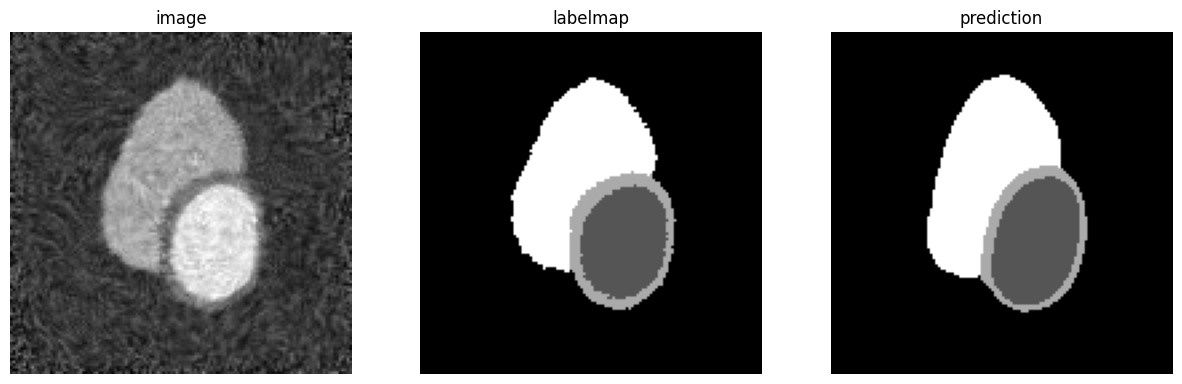

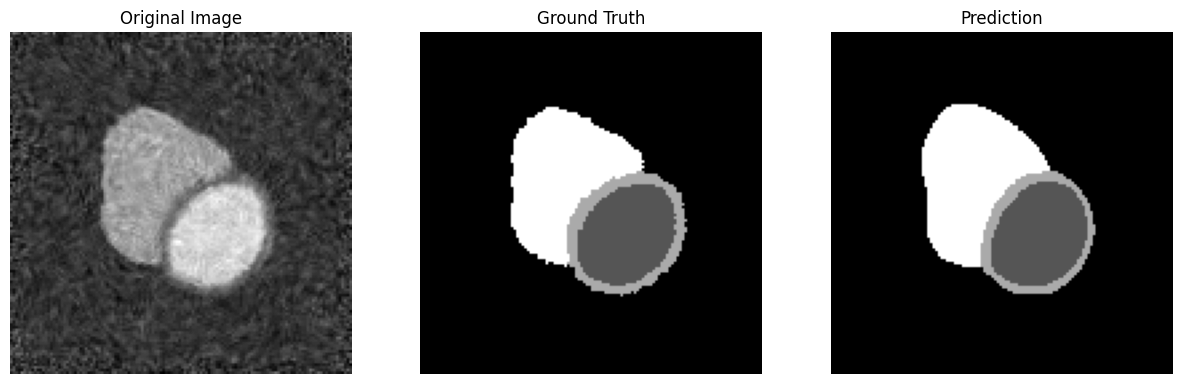

In [74]:
oss.probabilistic_sample = True
image_num = 0
batch = next(iter(data.test_dataloader()))
cuda_device = torch.device('cuda:0')
oss.num_iterations = 3
# batch['image'] = batch['image'][:2]

# batch['labelmap'] = batch['labelmap'][:2]
# batch['ground_truth'] = batch['ground_truth'][:2]
# move to gpu
batch = {k: v.to(cuda_device) for k, v in batch.items()}
oss.to(cuda_device)

with torch.no_grad():
    loss, dsc, probs, preds, _, _, _, attn = oss.process_batch(batch, 1)
image = batch['image'][image_num].squeeze().cpu()
labelmap = batch['ground_truth'][image_num].squeeze().cpu()
# probmap = torch.max(probs.cpu(), dim=1, keepdim=True)[0].squeeze().detach().numpy()
predmap = preds[image_num].squeeze().cpu()

f, ax = plt.subplots(1,3, figsize=(15, 15))

ax[0].imshow(image, cmap=matplotlib.cm.gray)
ax[0].axis('off')
ax[0].set_title('image')

ax[1].imshow(labelmap, cmap=matplotlib.cm.gray)
ax[1].axis('off')
ax[1].set_title('labelmap')

ax[2].imshow(predmap, cmap=matplotlib.cm.gray)
ax[2].axis('off')
ax[2].set_title('prediction')

# ax[3].imshow(probmap[image_num, ...], cmap='plasma')
# ax[3].axis('off')
# ax[3].set_title('probability map')

image_num += 1
image = batch['image'][image_num].squeeze().cpu()
labelmap = batch['ground_truth'][image_num].squeeze().cpu()
# probmap = torch.max(probs.cpu(), dim=1, keepdim=True)[0].squeeze().detach().numpy()
predmap = preds[image_num].squeeze().cpu()

f, ax = plt.subplots(1,3, figsize=(15, 15))

ax[0].imshow(image, cmap=matplotlib.cm.gray)
ax[0].axis('off')
ax[0].set_title('Original Image')

ax[1].imshow(labelmap, cmap=matplotlib.cm.gray)
ax[1].axis('off')
ax[1].set_title('Ground Truth')

ax[2].imshow(predmap, cmap=matplotlib.cm.gray)
ax[2].axis('off')
ax[2].set_title('Prediction')

# ax[3].imshow(probmap[image_num, ...], cmap='plasma')
# ax[3].axis('off')
# ax[3].set_title('probability map')

Loading Data:   0%|          | 0/3800 [00:00<?, ?it/s]

Loading Data: 100%|██████████| 1000/1000 [00:00<00:00, 1423245.33it/s]


Text(0.5, 1.0, 'Variance Map')

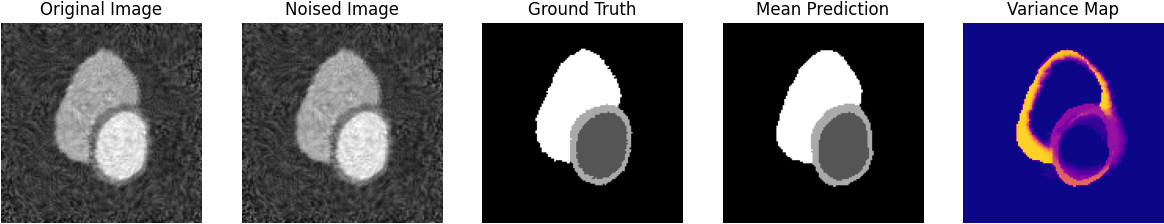

In [8]:
image_num = 0
data = SynthCardDataModule(batch_size=25, rate_maps=1.0, augmentation=False, cache=True, random_seed=42)
batch = next(iter(data.test_dataloader()))
cuda_device = torch.device('cuda:0')
batch = {k: v.to(cuda_device) for k, v in batch.items()}
oss.to(cuda_device)
oss.probabilistic_sample = False
noised_batch = batch.copy()
# transform = GaussianNoise(5)
noised_batch['image'] = noised_batch['image']
with torch.no_grad():
    loss, dsc, probs, preds, _, _, _, attn = oss.process_batch(noised_batch, 1)
image = batch['image'][image_num].squeeze().cpu()
noised_image = noised_batch['image'][image_num].squeeze().cpu()
labelmap = batch['ground_truth'][image_num].squeeze().cpu()
predmap = preds[image_num].squeeze().cpu()

f, ax = plt.subplots(1, 5, figsize=(15, 15))

ax[0].imshow(image, cmap=matplotlib.cm.gray)
ax[0].axis('off')
ax[0].set_title('Original Image')

ax[1].imshow(noised_image, cmap=matplotlib.cm.gray)
ax[1].axis('off')
ax[1].set_title('Noised Image')

ax[2].imshow(labelmap, cmap=matplotlib.cm.gray)
ax[2].axis('off')
ax[2].set_title('Ground Truth')

ax[3].imshow(predmap, cmap=matplotlib.cm.gray)
ax[3].axis('off')
ax[3].set_title('Mean Prediction')

# pixel_entropy = calculate_class_entropy(all_preds[image_num, ...].squeeze()).cpu()
pixel_entropy = torch.std(get_samples(oss, noised_batch), dim=1)[image_num].squeeze().cpu()
ax[4].imshow(pixel_entropy, cmap='plasma')
ax[4].axis('off')
ax[4].set_title('Variance Map')

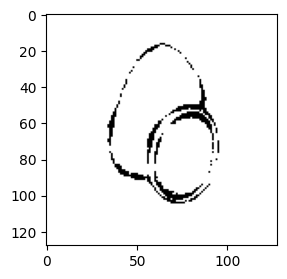

In [7]:
# show ground truth minus mean prediciton
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.imshow(labelmap == predmap, cmap='gray')

(-0.5, 127.5, 127.5, -0.5)

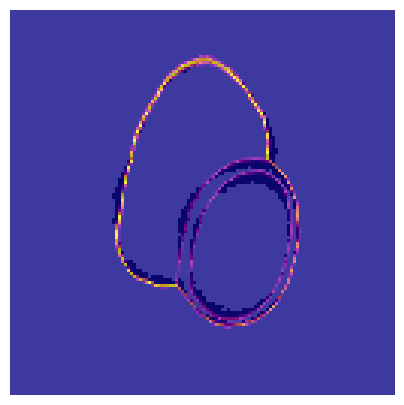

In [12]:
image_num = 0

f, ax = plt.subplots(1, 1, figsize=(5, 5))

# colorbar
# mappable = ax.imshow(pixel_entropy, cmap='plasma')
# f.colorbar(mappable, ax=ax)
ax.imshow(labelmap == predmap, cmap='gray')
ax.imshow(pixel_entropy, cmap='plasma', alpha=0.8)
ax.axis('off')
# ax.set_title('Prediction Entropy')

(-0.5, 127.5, 127.5, -0.5)

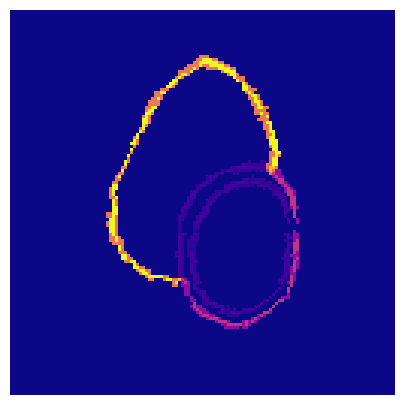

In [77]:
batch = next(iter(data.test_dataloader()))

var = torch.var(batch['labelmap'][image_num].float(), dim=0).squeeze().cpu()
f, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(var, cmap='plasma')
ax.axis('off')

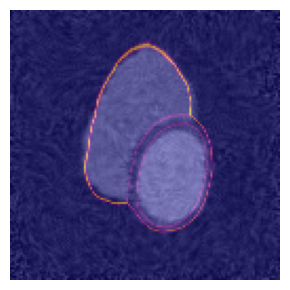

In [6]:
image_num = 0
batch = next(iter(data.test_dataloader()))
image = batch['image'][image_num].squeeze().cpu()
# image = image.squeeze().cpu()
batch = next(iter(data.test_dataloader()))
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

# Display the original image
ax.imshow(batch['image'][image_num].squeeze().cpu(), cmap='gray')

# Overlay the entropy map with some transparency
entropy_overlay = ax.imshow(pixel_entropy, cmap='plasma', alpha=0.5)

ax.axis('off')
# ax.set_title('Input Image with Entropy Map Overlay')

plt.tight_layout()
plt.show()

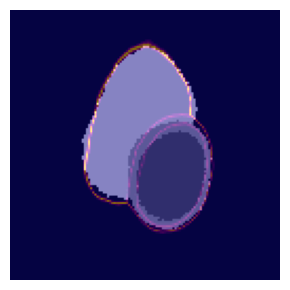

: 

In [7]:
# image_num = 0
# image = image.squeeze().cpu()
batch = next(iter(data.test_dataloader()))
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

# Display the original image
ax.imshow(batch['ground_truth'][image_num].squeeze().cpu(), cmap='gray')

# Overlay the entropy map with some transparency
entropy_overlay = ax.imshow(pixel_entropy, cmap='plasma', alpha=0.5)

ax.axis('off')
# ax.set_title('Input Image with Entropy Map Overlay')

plt.tight_layout()
plt.show()

In [9]:
data = SynthCardDataModule(batch_size=25, rate_maps=1.0, augmentation=False, cache=False, random_seed=42)
batch = next(iter(data.test_dataloader()))
ece_metric, aurc_metric = uncertainty_metrics(oss, batch, trials=500, transform='SpeckleNoise')

Loading Data: 100%|██████████| 1000/1000 [00:00<00:00, 554948.93it/s]


In [10]:
ece_metric.compute()

tensor(0.1238)

(<Figure size 600x600 with 1 Axes>,
 <AxesSubplot:xlabel='Coverage (%)', ylabel='Risk - Error Rate (%)'>)

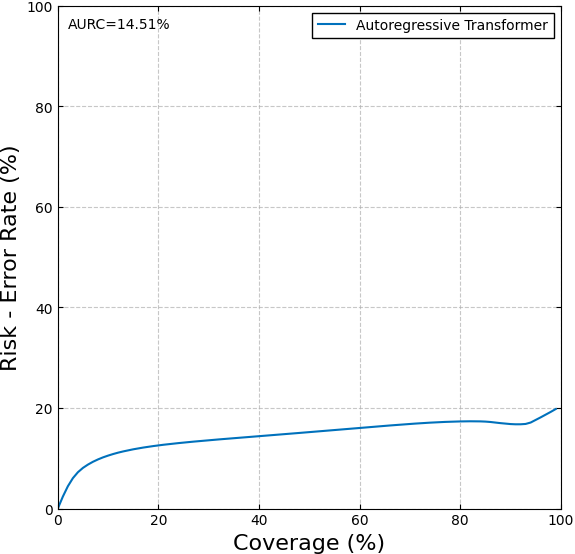

: 

In [11]:
aurc_metric.plot(name='Autoregressive Transformer')

In [25]:
data = SynthCardDataModule(batch_size=25, rate_maps=1.0, augmentation=False, cache=True, random_seed=42)

Loading Data: 100%|██████████| 1000/1000 [00:00<00:00, 727293.91it/s]


In [26]:
batch = next(iter(data.test_dataloader()))
print(len(batch['image']))

25


In [17]:
from torchmetrics.functional import dice
batch = next(iter(data.test_dataloader()))
batch = {k: v.to(cuda_device) for k, v in batch.items()}
gt = batch['ground_truth'].squeeze().to('cuda')
oss.to('cuda')
with torch.no_grad():
    loss, dsc, probs, preds, _, _, _, attn = oss.process_batch(batch, 1)
dsc = dice(preds, gt, average='macro', num_classes=4, ignore_index=0)
print(dsc)

tensor(0.8537, device='cuda:0')
